<a href="https://colab.research.google.com/github/NeuronsUII/Pathologies_ArtDental_n/blob/main/Kotov%20Alexander/04_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортируем библиотеки
import requests # модуль для работы с HTTP-запросами
from urllib.parse import urlencode # импортируем функцию обработки URL
import os # функции операционной системы
from PIL import Image # Отрисовка изображений
import matplotlib.pyplot as plt # Отрисовка графиков
import random # для работы с генератором случайных чисел
import numpy as np # Работа с numpy-массивами
from tensorflow.keras.models import Sequential # Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization # Основные слои
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras import utils # Функции-утилиты для работы с категориальными данными
from keras.models import load_model #  Загрузка предварительно обученной модели из файла
from sklearn.metrics import accuracy_score # для вычисления метрики точности (accuracy) в задачах классификации
# отображение графики в ячейках ноутбука
%matplotlib inline

In [ ]:
# Функция загрузки файлов c Яндекс диска в папку content на google
# ya_url - ссылка на файл (архив) на Яндекс диске (public key)
# filename - имя файла
def load_yandex_file_to_content(ya_url, filename):
    # Получаем загрузочную ссылку
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=ya_url))
    # запрос ссылки на скачивание
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его в папку content
    download_response = requests.get(download_url)
    with open(filename, 'wb') as f:
        f.write(download_response.content) # сохраняем файл в папку content на google

In [ ]:
TRAIN, TEST = 'train', 'test'
TRAIN_ZIP, TEST_ZIP = TRAIN + '.zip', TEST + '.zip'
# Загружаем архивы с обучающей (train.zip) и тестовой (test.zip) выборками с Яндекс диска в /content
load_yandex_file_to_content('https://disk.yandex.ru/d/dp__xZYRwgMxXw', TRAIN_ZIP) # данные для обучения
load_yandex_file_to_content('https://disk.yandex.ru/d/e9BO-S7zVpa-JA', TEST_ZIP)  # данные для тестирования

In [ ]:
# Распаковываем архивы
!unzip -o -q {TRAIN_ZIP}
!unzip -o -q {TEST_ZIP}
# Удаляем архивы, они нам больше не нужны для работы
os.remove(TRAIN_ZIP)
os.remove(TEST_ZIP)

In [ ]:
# Путь к папкам с обучающей и тестовой выборками
TRAIN_PATH = '/content/' + TRAIN.upper()
TEST_PATH = '/content/' + TEST.upper()
# Списки файлов в папках TRAIN и TEST
train_file_list = os.listdir(TRAIN_PATH)
test_file_list = os.listdir(TEST_PATH)
# Определяем списки имен классов
CLASS_LIST = ['Норма','Дистальное положение','Дистракция','Компрессия','Латеральное смещение','Медиальное смещение','Мезиальное положение']
# Наименования срезов
s_slice = {'А': 'Аксиальный', 'К': 'Корональный', 'С': 'Сагиттальный'}
# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)
# Выводим результат
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}\n')
for cls in CLASS_LIST:
    print(cls, ':', list(filter(lambda x: x[0] == str(CLASS_LIST.index(cls)), train_file_list)))

Количество классов: 7, метки классов: ['Норма', 'Дистальное положение', 'Дистракция', 'Компрессия', 'Латеральное смещение', 'Медиальное смещение', 'Мезиальное положение']

Норма : ['0СПП06Я07К10Р10К185.png', '0АПЛ04Я13К10Р10К185.png', '0КЛЛ04Я09К10Р10К13.png', '0СЛП00Я07К10Р10К13.png', '0КПЛ10Я10К11Р10К185.png', '0АПЛ02Я07К10Р10К185.png', '0СПП06Я10К11Р10К185.png', '0АПП00Я07К10Р10К185.png', '0АПЛ10Я13К10Р10К185.png', '0АПП06Я10К11Р10К13.png', '0АПЛ02Я07К10Р10К13.png', '0АПЛ02Я10К11Р10К13.png', '0КПП04Я10К11Р10К185.png', '0АПЛ08Я10К10Р11К13.png', '0АПП00Я10К10Р11К13.png', '0АПП08Я10К07Р10К13.png', '0АПЛ08Я13К10Р10К13.png', '0АПП02Я10К09Р10К13.png', '0АПЛ02Я10К07Р10К185.png', '0АПП04Я10К05Р10К13.png', '0КПЛ04Я10К11Р10К185.png', '0КЛП06Я10К09Р10К13.png', '0АПЛ04Я09К10Р10К13.png', '0СПП06Я10К07Р10К185.png', '0СЛЛ06Я11К10Р10К13.png', '0КПЛ06Я11К10Р10К185.png', '0СПЛ08Я10К11Р10К185.png', '0АПЛ04Я10К07Р10К13.png', '0АПЛ10Я10К09Р10К13.png', '0КЛП02Я10К09Р10К13.png', '0СЛЛ04Я11К10Р10К13.png', 

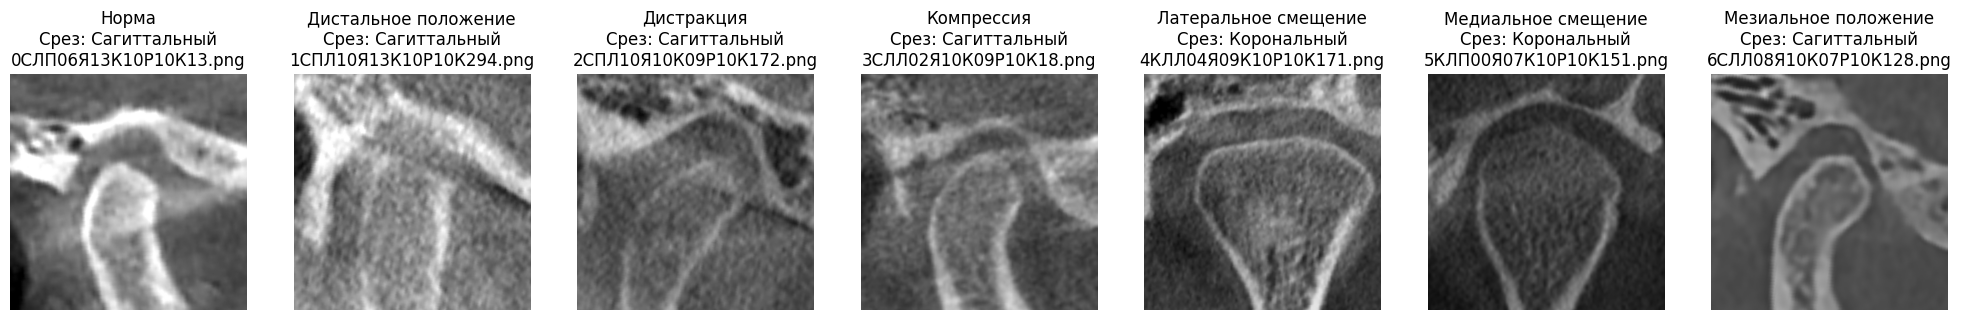

In [ ]:
# Отобразим по одному снимку из каждой патологии
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))
# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Выбор случайного фото из i-го класса
    fn = random.choice(list(filter(lambda x: x[0] == str(i), train_file_list)))
    img_path = TRAIN_PATH + '/' + fn
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i] + '\nСрез: ' + s_slice[fn[1]] + '\n'+ fn)
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка полотна
plt.show()

In [ ]:
# Список меток классов, соответствующих файлам
train_data_labels = [] # список меток для обучающей выборки
test_data_labels = []  # список меток для тестовой выборки
for i in train_file_list:
    train_data_labels.append(int(i[0]))
for i in test_file_list:
    test_data_labels.append(int(i[0]))
n = 5 # пример из n элементов
print('Файлы (' + str(n) + ' из ' + str(len(train_file_list)) + '): ' , train_file_list[:n], '...')
print('Их метки классов (' + str(n) + ' из ' + str(len(train_data_labels)) + '): ' , train_data_labels[:n], '...')
print('\nКоличество файлов по классам в обучающей выборке:')
for i in range(CLASS_COUNT):
    print(' ▪ ',CLASS_LIST[i].lower(),': ', train_data_labels.count(i))
print('\nКоличество файлов по классам в тестовой выборке:')
for i in range(CLASS_COUNT):
    print(' ▪ ',CLASS_LIST[i].lower(),': ', test_data_labels.count(i))

Файлы (5 из 3276):  ['3СЛЛ10Я11К10Р10К18.png', '2СПП00Я10К10Р10К172.png', '2СПП08Я10К10Р11К245.png', '0СПП06Я07К10Р10К185.png', '1СПП00Я07К10Р10К153.png'] ...
Их метки классов (5 из 3276):  [3, 2, 2, 0, 1] ...

Количество файлов по классам в обучающей выборке:
 ▪  норма :  546
 ▪  дистальное положение :  364
 ▪  дистракция :  273
 ▪  компрессия :  364
 ▪  латеральное смещение :  728
 ▪  медиальное смещение :  546
 ▪  мезиальное положение :  455

Количество файлов по классам в тестовой выборке:
 ▪  норма :  6
 ▪  дистальное положение :  0
 ▪  дистракция :  0
 ▪  компрессия :  0
 ▪  латеральное смещение :  4
 ▪  медиальное смещение :  4
 ▪  мезиальное положение :  0


In [ ]:
# Формирование набора данных из имеющейся базы
# train_file_list и test_file_list - списки с именами файлов изображений
# train_data_labels и tеst_data_labels - метки (номера) классов, соответствующие файлам изображений из списков train_file_list и test_file_list

# Приведем изображения к одному размеру
# (поскольку при аугментации применялся "поворот изображения с обрезанием", размеры изображений стали чуть меньше изначального размера 600 х 600)
IMG_WIDTH  = 128 # Ширина изображения
IMG_HEIGHT = 128 # Высота изображения

# Обучающая выборка
train_data_images = [] # массив данных обучающей выборки
for file_name in train_file_list:
    # Открытие и смена размера изображения
    img = Image.open(TRAIN_PATH + '/' + file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    # Приведем все изображения к формату (ширина, высота, 3).
    # Т.к. некоторые PNG-изображения могут быть в формате RGBA (четыре канала: RGB и альфа-канал),
    # что приводит к форме (ширина, высота, 4), а не (ширина, высота, 3).
    # А для изображений в оттенках серого с альфа каналом размерность будет (ширина, высота, 2).
    # Аргументы для convert: 1 - однобитное изображение (0-черный, 1-белый), L - оттенки серого, RGB - трехканальное и др.
    # img_cvt = img.convert('RGB')          # приводим к формату RGB (ширина, высота, 3)
    img_cvt = img.convert('L')             # приводим к формату "оттенки серого" (ширина, высота)
    img_np = np.array(img_cvt)             # Перевод в numpy-массив
    # Нормирование массива: приводим от диапазона 0 .. 255 к диапазону 0.0 .. 1.0
    img_np = img_np / 255.
    train_data_images.append(img_np)       # Добавление изображения снимка в виде numpy-массива к общему списку
x_data_train = np.array(train_data_images) # Перевод общего списка изображений в numpy-массив
y_data_train = np.array(train_data_labels) # Перевод общего списка меток класса в numpy-массив

# Тестовая выборка
test_data_images = [] # массив данных обучающей выборки
for file_name in test_file_list:
    # Открытие и смена размера изображения
    img = Image.open(TEST_PATH + '/' + file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    #img_cvt = img.convert('RGB')           # приводим к формату RGB (ширина, высота, 3)
    img_cvt = img.convert('L')             # приводим к формату "оттенки серого" (ширина, высота)
    img_np = np.array(img_cvt)             # Перевод в numpy-массив
    # Нормирование массива: приводим от диапазона 0 .. 255 к диапазону 0.0 .. 1.0
    img_np = img_np / 255.
    test_data_images.append(img_np)        # Добавление изображения снимка в виде numpy-массива к общему списку
x_data_test = np.array(test_data_images)   # Перевод общего списка изображений в numpy-массив
y_data_test = np.array(test_data_labels)   # Перевод общего списка меток класса в numpy-массив

In [ ]:
# Выводим результат
print('\033[1mОБУЧАЮЩАЯ ВЫБОРКА:\033[0m')
print(f'В массив собрано {len(train_data_images)} изображений в формате: {img_np.shape}')
print(f'Общий массив данных в формате: {x_data_train.shape}')
print(f'Общий массив меток классов в формате: {y_data_train.shape}')
print('\n\033[1mТЕСТОВАЯ ВЫБОРКА:\033[0m')
print(f'В массив собрано {len(test_data_images)} изображений в формате: {img_np.shape}')
print(f'Общий массив данных в формате: {x_data_test.shape}')
print(f'Общий массив меток классов в формате: {y_data_test.shape}')

ОБУЧАЮЩАЯ ВЫБОРКА:
В массив собрано 3276 изображений в формате: (128, 128)
Общий массив данных в формате: (3276, 128, 128)
Общий массив меток классов в формате: (3276,)

ТЕСТОВАЯ ВЫБОРКА:
В массив собрано 14 изображений в формате: (128, 128)
Общий массив данных в формате: (14, 128, 128)
Общий массив меток классов в формате: (14,)


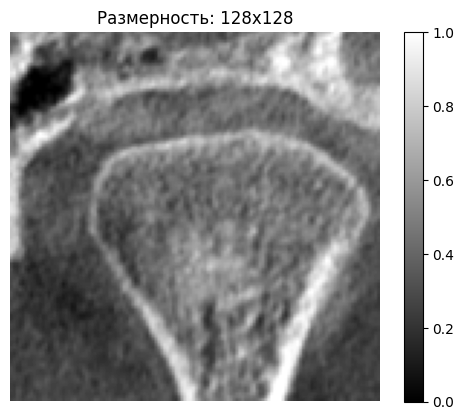

In [ ]:
# Выведем из numpy-массива пример преобразованного изображения
n = 213 # номер элемента в numpy-массиве
if n < 0:
    n = 0
if n >= len(x_data_train):
    n = len(x_data_train) - 1
plt.imshow(x_data_train[n], cmap='gray')
plt.axis('off')
plt.title('Размерность: '+ str(x_data_train[n].shape[0]) + 'x' + str(x_data_train[n].shape[1]))
plt.colorbar()  # Добавление шкалы для отображения соответствия значений и цветов
plt.show()

# Создаем сверточную сеть

In [ ]:

model = Sequential()

model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization(name='First_B'))

model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))

model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))
model.add(BatchNormalization(name='Third_B'))
model.add(Dropout(0.2, name='Third_D'))

model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))
model.add(Dropout(0.2, name='Fourth_D'))

model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))
model.add(BatchNormalization(name='Fifth_B'))

model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))
model.add(Dropout(0.2, name='Sixth_D'))

model.add(Flatten(name='Class_1'))
model.add(Dense(2048, activation='relu', name='Class_2'))
model.add(Dense(4096, activation='relu', name='Class_3'))
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_C (Conv2D)            (None, 128, 128, 256)     2560      
                                                                 
 First_B (BatchNormalizatio  (None, 128, 128, 256)     1024      
 n)                                                              
                                                                 
 Second_C (Conv2D)           (None, 128, 128, 256)     590080    
                                                                 
 Second_M (MaxPooling2D)     (None, 42, 42, 256)       0         
                                                                 
 Third_C (Conv2D)            (None, 42, 42, 256)       590080    
                                                                 
 Third_B (BatchNormalizatio  (None, 42, 42, 256)       1024      
 n)                                                     

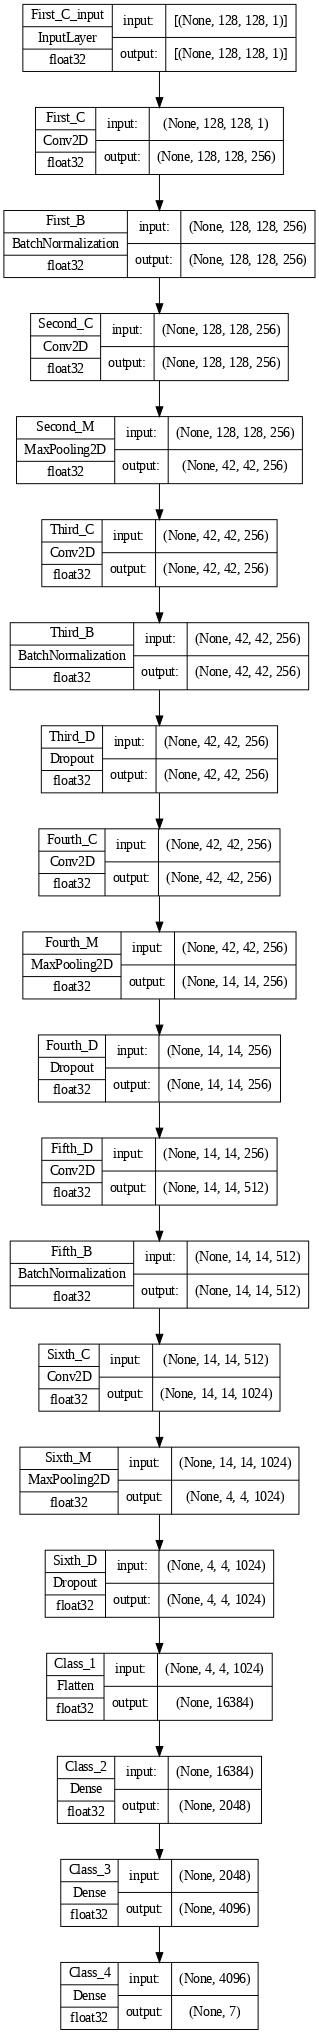

In [ ]:
# Отобразим архитектуру модели
model.summary()
utils.plot_model(model, dpi=70, show_shapes=True, show_dtype=True)

In [ ]:
# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Обучение модели сверточной нейронной сети

x_data_train = np.expand_dims(x_data_train, axis=-1) # Для ч/б картинок формата (ширина, высота) добавляем размерность (ширина, высота, 1) перед подачей в НС

store_learning = model.fit(x_data_train,  # массив обучающего набора данных
                           y_data_train,  # массив меток примеров набора данных
                           validation_split=0.2,  # 0.2 - доля данных для валидационной (проверочной) выборки, 0.8 остается в обучающей
                           shuffle=True,  # перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=16, # размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=10,     # количество эпох обучения
                           verbose=1)     # 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/10
164/164 [==============================] - 59s 264ms/step - loss: 0.9391 - accuracy: 0.7802 - val_loss: 1.9559 - val_accuracy: 0.2241
Epoch 2/10
164/164 [==============================] - 37s 227ms/step - loss: 0.0903 - accuracy: 0.9737 - val_loss: 1.7045 - val_accuracy: 0.3887
Epoch 3/10
164/164 [==============================] - 39s 237ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.3895 - val_accuracy: 0.9085
Epoch 4/10
164/164 [==============================] - 40s 243ms/step - loss: 4.4570e-04 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 5/10
164/164 [==============================] - 39s 239ms/step - loss: 2.6193e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
164/164 [==============================] - 40s 243ms/step - loss: 1.6548e-04 - accuracy: 1.0000 - val_loss: 4.2172e-04 - val_accuracy: 1.0000
Epoch 7/10
164/164 [==============================] - 40s 241ms/step - loss: 1.6252e-04 - accuracy: 1.0000 - val_l

In [ ]:
# Сохраним обученную модель в файл в формате Keras:
# - архитектуру модели, включая типы и параметры всех слоев;
# - веса всех слоев модели;
# - конфигурацию оптимизатора, который был использован для обучения модели;
# - конфигурацию коллбэков, если они были использованы в процессе обучения модели.
model.save('/content/model.keras')

In [ ]:
# Загрузка модели из файла:
model = load_model('/content/model.keras')

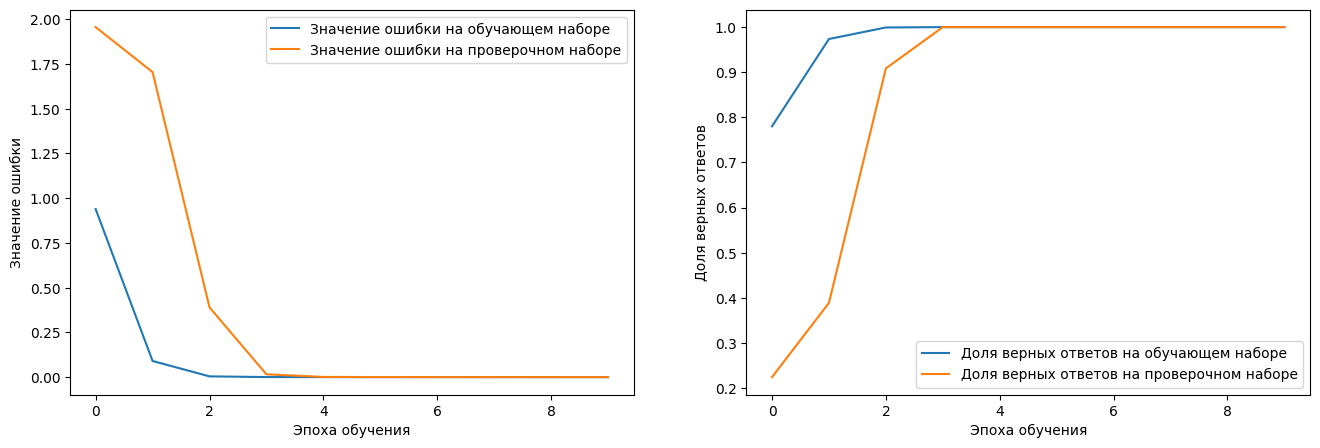

In [ ]:
# Результаты обучения
# Создание полотна для рисунка
plt.figure(1, figsize=(16, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Подпишем оси
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Вывод графиков
plt.show()

In [ ]:
# Получение предсказаний модели для тестового набора данных
x_data_test = np.expand_dims(x_data_test, axis=-1)  # Добавляем размерность канала
predictions = model.predict(x_data_test)
# Преобразование вероятностных предсказаний в метки классов
predicted_labels = np.argmax(predictions, axis=1)
# Оценка правильности классификации
accuracy = accuracy_score(y_data_test, predicted_labels)
# Цвет: зеленый - положительный результат работы модели, красный - отрицательный
colf = '\033[91m' if accuracy < 0.75 else '\033[32m' # 75%
print('Результат работы модели на тестовых данных:\033[1m' + colf, round(accuracy * 100, 2), '%\033[0m\n')
# Вывод
for i in range(len(y_data_test)): # x_data_test):
    colf = '\033[91m' if y_data_test[i] != predicted_labels[i] else '\033[32m'
    print('ТЕСТ ' + str(i + 1).zfill(2)[-2:] + ' (' + CLASS_LIST[y_data_test[i]].lower() + '): ' +
          colf + CLASS_LIST[predicted_labels[i]].upper() + ' (' +
          str(round(np.max(predictions[i][predicted_labels[i]]) * 100, 2)) + '%)\033[0m')

1/1 [==============================] - 3s 3s/step
Результат работы модели на тестовых данных: 35.71 %

ТЕСТ 01 (норма): НОРМА (72.95%)
ТЕСТ 02 (норма): КОМПРЕССИЯ (57.65%)
ТЕСТ 03 (норма): МЕЗИАЛЬНОЕ ПОЛОЖЕНИЕ (97.55%)
ТЕСТ 04 (медиальное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (72.74%)
ТЕСТ 05 (медиальное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (87.93%)
ТЕСТ 06 (медиальное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (99.63%)
ТЕСТ 07 (медиальное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (49.01%)
ТЕСТ 08 (латеральное смещение): НОРМА (99.85%)
ТЕСТ 09 (норма): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (100.0%)
ТЕСТ 10 (латеральное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (99.13%)
ТЕСТ 11 (латеральное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (84.06%)
ТЕСТ 12 (норма): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (92.46%)
ТЕСТ 13 (норма): НОРМА (99.45%)
ТЕСТ 14 (латеральное смещение): ЛАТЕРАЛЬНОЕ СМЕЩЕНИЕ (99.22%)
